# 0. Import packages

In [2]:
!pip install optuna &> /dev/null
!pip install category_encoders  &> /dev/null
!pip install geopandas &> /dev/null

In [3]:
import os

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


# 1. Load Base Dataset

In [6]:
INPUT_DIR='data/MyDrive/kaist-ie343-2023-spring'
OUTPUT_DIR='data/MyDrive/kaist-ie343-2023-spring'

In [25]:
## Do not change this cell. 
## The reason for this is to prevent cheating using the original data from DACON. 
## If an assertion error occurs in that cell when TAs evaluate the submitted code of each student, it is considered cheating.

train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
park = pd.read_csv(os.path.join(INPUT_DIR, 'park.csv'))
dcc = pd.read_csv(os.path.join(INPUT_DIR, 'day_care_center.csv'))

assert train.shape[0] == 329690 and train.shape[1] == 13, 'Do not change the format of the input data.'
assert test.shape[0] == 85097 and test.shape[1] == 12, 'Do not change the format of the input data.'
assert park.shape[0] == 1359 and park.shape[1] == 7, 'Do not change the format of the input data.'
assert dcc.shape[0] == 7373 and dcc.shape[1] == 10, 'Do not change the format of the input data.'

# 2. Load additional dataset

- I have used the subway dataset from Kaggle, contains the locations of subway stations in seoul.
- Another dataset is used from Mendely that contains subway locations for busan city. Look at the report for more explanation.

In [26]:
import geopandas as gd

busan_subway  = gd.read_file(os.path.join(INPUT_DIR, 'Busan_subway.shp')).to_crs(epsg=4326)
busan_subway['lat'] = busan_subway['geometry'].apply(lambda x: x.y)
busan_subway['lon'] = busan_subway['geometry'].apply(lambda x: x.x)

busan_subway = busan_subway[['lat', 'lon']]

seoul_subway = pd.read_csv(os.path.join(INPUT_DIR, 'seoul_subway.csv'))
seoul_subway = seoul_subway[['lat', 'lng']]

# busan_subway
# seoul_subway

# 3. EDA and Preprocessing

## Handle Missing Values

Apartments from 0 - 4419 in both train and test(test missing some apartment Ids).

In [27]:
for i in test['apartment_id'].unique():
  print(i in train['apartment_id'].unique()) if False else ' '

In [28]:
nan_ids_train = train[train.lat.isna()]['apartment_id'].unique()
nan_ids_test = test[test.lat.isna()]['apartment_id'].unique()

Dong 113 in busan latitude and longitude values are not known for apartment_ids 
- 136,  311, 1743, 2841, 4141, 4410 in train and 
- 136, 1743, 2841, 4141 in test

To fill the missing latitude and longitude 
 - take the mean /median of the lat, long in busan
 - sample from N(mu, std) for each apt_id

In [29]:
m = train[train['city'] == 'busan'][['lat', 'long']].median()

for id in nan_ids_train:

  sample = np.random.normal(loc = m.to_numpy(), scale=(0.02, 0.03))

  train.loc[train['apartment_id'] == id, 'long'] = sample[1]
  train.loc[train['apartment_id'] == id, 'lat'] = sample[0]

  if id in nan_ids_test:
    test.loc[test['apartment_id'] == id, 'long'] = sample[1]
    test.loc[test['apartment_id'] == id, 'lat'] = sample[0]

assert np.all(test.isna().sum().values == 0)
assert np.all(train.isna().sum().values == 0)

# Parks Dataset

In [30]:
park_cp = park.copy().drop(['park_name', 'park_open_year'], axis=1)

park_cp['park_type'], _= pd.factorize(park_cp['park_type'])
park_cp['park_num'] = 1

park_sum_count = park_cp.groupby(['city', 'gu', 'dong']).agg({'park_area':'sum', 'park_num':'count'}).reset_index()
park_cp = park_sum_count.merge(park_cp[['city', 'gu', 'dong', 'park_type']], on=['city', 'gu', 'dong'])

dcc_filtered = dcc.drop(['nursing_room_num', 'teacher_num', 'playground_num', 'CCTV_num', 'is_commuting_vehicle', 'day_care_name'], axis=1)
dcc_filtered['day_care_type'], _= pd.factorize(dcc_filtered['day_care_type'])

park_combined = park_cp.merge(dcc_filtered, on = ['city', 'gu'])
park_combined = park_combined.drop_duplicates(subset=['city', 'dong'])

com_train = train.merge(park_combined, on=['city', 'dong'], how='left')
com_test = test.merge(park_combined, on=['city', 'dong'], how='left')

sorted_type = com_train.groupby('day_care_type')[['PRICE']].mean().sort_values("PRICE", ascending=False)
sorted_type['new_idx'] = list(range(len(sorted_type)))

sorted_type = sorted_type[['new_idx']].to_dict()['new_idx']

com_train['day_care_type'] = com_train['day_care_type'].apply(lambda x: sorted_type[x])
com_test['day_care_type'] = com_test['day_care_type'].apply(lambda x: sorted_type[x])


sorted_type = com_train.groupby('park_type')[['PRICE']].mean().sort_values("PRICE", ascending=False)
sorted_type['new_idx'] = list(range(len(sorted_type)))

sorted_type = sorted_type[['new_idx']].to_dict()['new_idx']

com_train['park_type'] = com_train['park_type'].apply(lambda x: sorted_type[x])
com_test['park_type'] = com_test['park_type'].apply(lambda x: sorted_type[x])

In [31]:
com_train

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE,gu,park_area,park_num,park_type,day_care_type,day_care_baby_num
0,0,0,busan,197,125.865988,1993,5,35.149929,129.006071,2021,7,11~20,229250.80,18,244.075200,7,3,5,93
1,1,0,busan,197,101.647190,1993,12,35.149929,129.006071,2021,10,1~10,215320.00,18,244.075200,7,3,5,93
2,2,0,busan,197,91.511175,1993,6,35.149929,129.006071,2020,3,21~31,161740.00,18,244.075200,7,3,5,93
3,3,0,busan,197,101.647190,1993,13,35.149929,129.006071,2020,5,11~20,199781.80,18,244.075200,7,3,5,93
4,4,0,busan,197,101.647190,1993,4,35.149929,129.006071,2022,6,21~30,219606.40,18,244.075200,7,3,5,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,329685,4419,seoul,37,101.431912,2014,4,37.452039,127.070842,2022,5,21~31,885070.00,22,172.214818,5,3,0,107
329686,329686,4419,seoul,37,101.431912,2014,14,37.452039,127.070842,2021,10,1~10,826132.00,22,172.214818,5,3,0,107
329687,329687,4419,seoul,37,71.687641,2014,2,37.452039,127.070842,2022,11,21~30,697540.00,22,172.214818,5,3,0,107
329688,329688,4419,seoul,37,137.192013,2014,18,37.452039,127.070842,2020,9,21~30,870656.98,22,172.214818,5,3,0,107


In [32]:
train = com_train.drop('index', axis=1)
test = com_test.drop('index', axis=1)

train.index = com_train['index']
test.index = com_test['index']

# Use Additional Data

In [33]:
train

,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE,gu,park_area,park_num,park_type,day_care_type,day_care_baby_num
index,,,,,,,,,,,,,,,,,,
0,0,busan,197,125.865988,1993,5,35.149929,129.006071,2021,7,11~20,229250.80,18,244.075200,7,3,5,93
1,0,busan,197,101.647190,1993,12,35.149929,129.006071,2021,10,1~10,215320.00,18,244.075200,7,3,5,93
2,0,busan,197,91.511175,1993,6,35.149929,129.006071,2020,3,21~31,161740.00,18,244.075200,7,3,5,93
3,0,busan,197,101.647190,1993,13,35.149929,129.006071,2020,5,11~20,199781.80,18,244.075200,7,3,5,93
4,0,busan,197,101.647190,1993,4,35.149929,129.006071,2022,6,21~30,219606.40,18,244.075200,7,3,5,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,4419,seoul,37,101.431912,2014,4,37.452039,127.070842,2022,5,21~31,885070.00,22,172.214818,5,3,0,107
329686,4419,seoul,37,101.431912,2014,14,37.452039,127.070842,2021,10,1~10,826132.00,22,172.214818,5,3,0,107
329687,4419,seoul,37,71.687641,2014,2,37.452039,127.070842,2022,11,21~30,697540.00,22,172.214818,5,3,0,107


In [34]:
seoul = train[train['city'] == 'seoul']
busan = train[train['city'] == 'busan']

test_seoul = test[test['city'] == 'seoul']
test_busan = test[test['city'] == 'busan']

In [35]:
Haeundae_lat = 35.1587
Haeundae_lon = 129.1604

Gang_lat = 37.4967
Gang_long = 127.0630

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371.0 * c
    return km

######################### BUSAN
lat1 = busan['lat'].values
lon1 = busan['long'].values

lat2 = busan_subway['lat'].values
lon2 = busan_subway['lon'].values

distance = haversine(lat1, lon1, Haeundae_lat, Haeundae_lon)
busan['hundae_gangnam'] = distance

crow_distances = haversine(lat1[:, None], lon1[:, None], lat2, lon2)
busan['crow_dist'] = np.min(crow_distances, axis=1)
busan['crow_dist2'] = np.sum(np.partition(crow_distances, 2)[:, :3], axis=1)



lat1 = test_busan['lat'].values
lon1 = test_busan['long'].values

distance = haversine(lat1, lon1, Haeundae_lat, Haeundae_lon)
test_busan['hundae_gangnam'] = distance

# Calculate the distance from each apartment to all 
crow_distances = haversine(lat1[:, None], lon1[:, None], lat2, lon2)
test_busan['crow_dist'] = np.min(crow_distances, axis=1)
test_busan['crow_dist2'] = np.sum(np.partition(crow_distances, 2)[:, :3], axis=1)

########################## SEOUL
lat1 = seoul['lat'].values
lon1 = seoul['long'].values

lat2 = seoul_subway['lat'].values
lon2 = seoul_subway['lng'].values

distance = haversine(lat1, lon1, Gang_lat, Gang_long)
seoul['hundae_gangnam'] = distance

crow_distances = haversine(lat1[:, None], lon1[:, None], lat2, lon2)
seoul['crow_dist'] = np.min(crow_distances, axis=1)
seoul['crow_dist2'] = np.sum(np.partition(crow_distances, 2)[:, :3], axis=1)


lat1 = test_seoul['lat'].values
lon1 = test_seoul['long'].values

distance = haversine(lat1, lon1, Gang_lat, Gang_long)
test_seoul['hundae_gangnam'] = distance

# Calculate the distance from each apartment to all 
crow_distances = haversine(lat1[:, None], lon1[:, None], lat2, lon2)
test_seoul['crow_dist'] = np.min(crow_distances, axis=1)
test_seoul['crow_dist2'] = np.sum(np.partition(crow_distances, 2)[:, :3], axis=1)

####################################
test = pd.concat([test_seoul, test_busan])
train = pd.concat([busan, seoul])

del seoul
del busan
del test_seoul
del test_busan

train.columns

Index(['apartment_id', 'city', 'dong', 'house_area', 'built_year', 'floor',
       'lat', 'long', 'transaction_year', 'transaction_month',
       'transaction_day', 'PRICE', 'gu', 'park_area', 'park_num', 'park_type',
       'day_care_type', 'day_care_baby_num', 'hundae_gangnam', 'crow_dist',
       'crow_dist2'],
      dtype='object')

In [24]:
test

,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,gu,park_area,park_num,park_type,day_care_type,day_care_baby_num,hundae_gangnam,crow_dist,crow_dist2
index,,,,,,,,,,,,,,,,,,,,
329718,2,seoul,93,100.102210,2002,9,37.576820,126.814220,2023,3,21~31,3,1673.580920,25,0,1,49,23.675879,0.147761,2.064681
329719,2,seoul,93,101.213644,2002,7,37.576820,126.814220,2023,4,11~20,3,1673.580920,25,0,1,49,23.675879,0.147761,2.064681
329720,3,seoul,179,101.539551,2006,6,37.592657,126.921611,2023,3,1~10,31,802.008495,9,6,2,20,16.408351,0.723057,3.008675
329721,3,seoul,179,101.539551,2006,3,37.592657,126.921611,2023,5,21~31,31,802.008495,9,6,2,20,16.408351,0.723057,3.008675
329735,5,seoul,14,93.634057,2003,6,37.502385,126.862850,2023,2,21~28,6,934.823464,9,3,1,35,17.668011,0.939555,3.024528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414710,4418,busan,171,101.647190,1988,10,35.161840,129.142776,2023,6,1~10,35,589.473500,5,3,1,58,1.639729,0.512041,2.170302
414711,4418,busan,171,101.290785,1988,12,35.161840,129.142776,2023,6,1~10,35,589.473500,5,3,1,58,1.639729,0.512041,2.170302
414712,4418,busan,171,101.290785,1988,3,35.161840,129.142776,2023,6,1~10,35,589.473500,5,3,1,58,1.639729,0.512041,2.170302


In [21]:
train

,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,...,PRICE,gu,park_area,park_num,park_type,day_care_type,day_care_baby_num,hundae_gangnam,crow_dist,crow_dist2
index,,,,,,,,,,,,,,,,,,,,,
0,0,busan,197,125.865988,1993,5,35.149929,129.006071,2021,7,...,229250.80,18,244.075200,7,3,5,93,14.064462,0.267518,2.206177
1,0,busan,197,101.647190,1993,12,35.149929,129.006071,2021,10,...,215320.00,18,244.075200,7,3,5,93,14.064462,0.267518,2.206177
2,0,busan,197,91.511175,1993,6,35.149929,129.006071,2020,3,...,161740.00,18,244.075200,7,3,5,93,14.064462,0.267518,2.206177
3,0,busan,197,101.647190,1993,13,35.149929,129.006071,2020,5,...,199781.80,18,244.075200,7,3,5,93,14.064462,0.267518,2.206177
4,0,busan,197,101.647190,1993,4,35.149929,129.006071,2022,6,...,219606.40,18,244.075200,7,3,5,93,14.064462,0.267518,2.206177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,4419,seoul,37,101.431912,2014,4,37.452039,127.070842,2022,5,...,885070.00,22,172.214818,5,3,0,107,5.014053,1.443422,8.650589
329686,4419,seoul,37,101.431912,2014,14,37.452039,127.070842,2021,10,...,826132.00,22,172.214818,5,3,0,107,5.014053,1.443422,8.650589
329687,4419,seoul,37,71.687641,2014,2,37.452039,127.070842,2022,11,...,697540.00,22,172.214818,5,3,0,107,5.014053,1.443422,8.650589


# Combining features

Transaction day, month and year

The transaction dates '21\~30', 21\~28', and 21~29' represent the same end-of-month time so are combined together

<Axes: xlabel='transaction_day', ylabel='PRICE'>

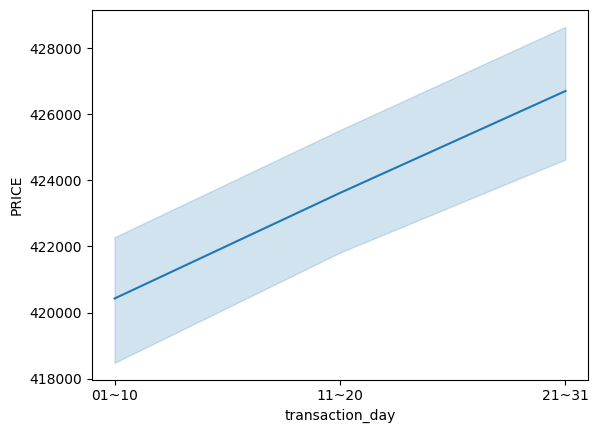

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

train.loc[train['transaction_day'] == '21~30', 'transaction_day'] = '21~31'
train.loc[train['transaction_day'] == '21~28', 'transaction_day'] = '21~31'
train.loc[train['transaction_day'] == '21~29', 'transaction_day'] = '21~31'

train.loc[train['transaction_day'] == '1~10', 'transaction_day'] = '01~10'

sns.lineplot(data = train.sort_values('transaction_day'), x ='transaction_day', y = 'PRICE')

# del train['transaction_day']



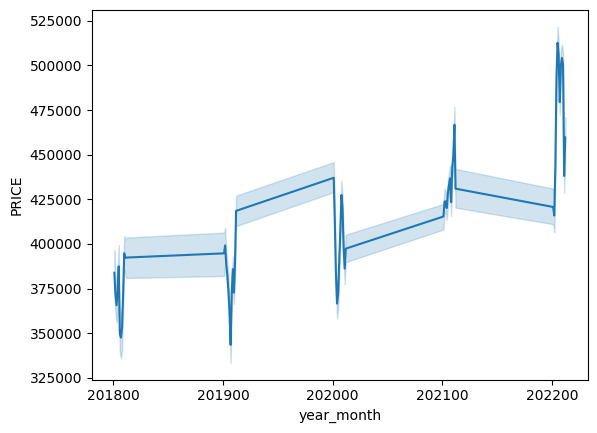

In [ ]:
train['year_month'] = train['transaction_year'].astype(str) + train['transaction_month'].astype(str).str.zfill(2)
train['year_month'] = train['year_month'].astype(int) 

sns.lineplot(data = train, x ='year_month', y = 'PRICE')

del train['year_month']

transaction and built year

Here we are keeping the age and the tran_minus_built.

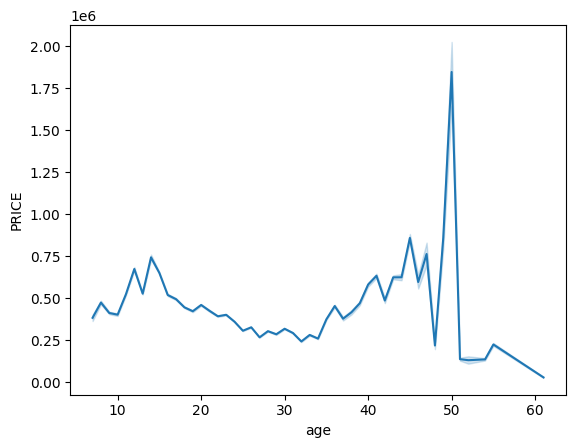

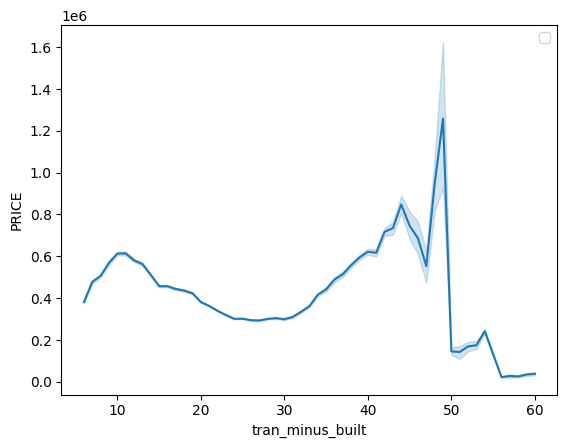

In [39]:
train['age'] = 2023 - train['built_year']
train['tran_minus_built'] = train['transaction_year'] - train['built_year']

sns.lineplot(data = train, x ='age', y = 'PRICE')
plt.show()
sns.lineplot(data = train, x = 'tran_minus_built', y='PRICE')

del train['age']
del train['tran_minus_built']

Floor

Here keeping floor as is

The differece between the floor and the max for that building is calculated

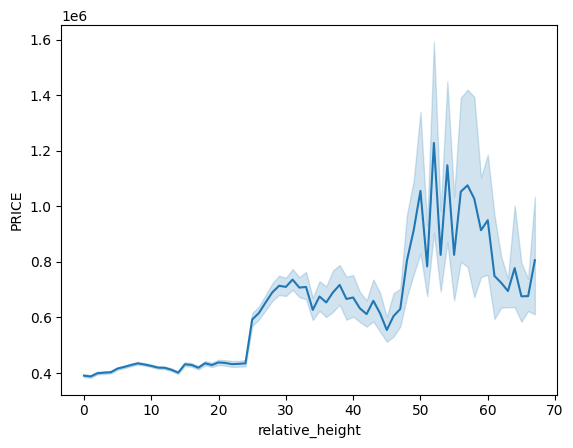

In [ ]:
# Find the maximum floor for each apartment_id
max_floor = train.groupby('apartment_id')['floor'].transform('max')

# Subtract each apartment's floor from the maximum floor of its building
train['relative_height'] = max_floor - train['floor']

sns.lineplot(data = train, x ='relative_height', y = 'PRICE')

del train['relative_height']

House Area

House area is standardized.

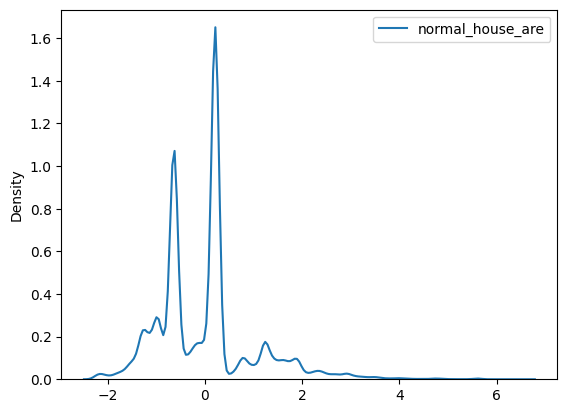

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train['normal_house_are'] = (train['house_area'] - train['house_area'].mean()) / train['house_area'].std()
# sns.kdeplot(data = train[['house_area']])
sns.kdeplot(data = train[['normal_house_are']])


del train['normal_house_are'] 

City

factorized as busan - 0 and seoul 1

<Axes: xlabel='city', ylabel='PRICE'>

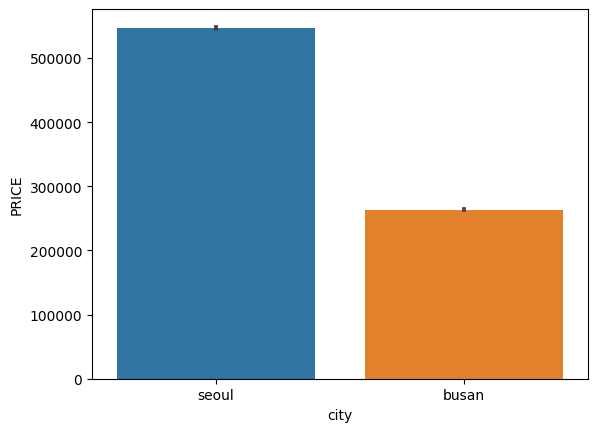

In [ ]:
sns.barplot(data = train, x ='city', y = 'PRICE')

lat and long

Keep them as if for now and check with cross validation

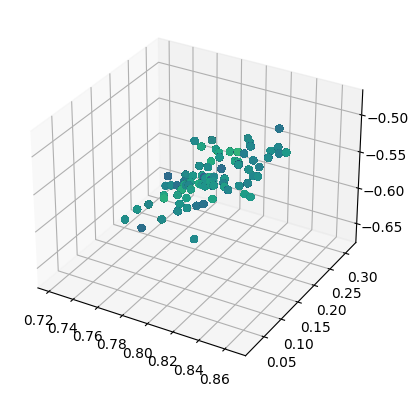

In [ ]:
lat = train['lat']
lon = train['long']
train['x_coor'] = np.cos(lat) * np.cos(lon)
train['y_coor'] = np.cos(lat) * np.sin(lon)
train['z_coor'] = np.sin(lat)

train['log_price'] = np.log1p(train['PRICE'])

# sns.scatterplot(data = train[train['city'] == 'busan'], x = 'x_coor', y='z_coor', hue='log_price')

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

seoul = train[train['city'] == 'busan']

ax.scatter(seoul['x_coor'], seoul['y_coor'], seoul['z_coor'], c = seoul['log_price'])

del train['x_coor']
del train['y_coor']
del train['z_coor']
del train['log_price']

Apt Id
sort based on the price

In [36]:
for i in test['apartment_id'].unique():
  if not i in train['apartment_id'].unique():
    print(i)

4391


In [40]:
min_year = train['transaction_year'].min()
srt = train.groupby('apartment_id')[['PRICE']].mean().sort_values("PRICE", ascending=False)
srt['new_idx'] = list(range(len(srt)))

srt = srt[['new_idx']].to_dict()['new_idx']
srt[4391] = -1 # np.mean(list(range(len(srt))))

train['new_idx'] = train['apartment_id'].apply(lambda x: srt[x])
del train['new_idx']

from sklearn.decomposition import PCA, FastICA

pca = PCA(n_components = 1)
ica = FastICA(n_components=1)

In [41]:
test

,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,gu,park_area,park_num,park_type,day_care_type,day_care_baby_num,hundae_gangnam,crow_dist,crow_dist2
index,,,,,,,,,,,,,,,,,,,,
329718,2,seoul,93,100.102210,2002,9,37.576820,126.814220,2023,3,21~31,3,1673.580920,25,0,1,49,23.675879,0.147761,2.064681
329719,2,seoul,93,101.213644,2002,7,37.576820,126.814220,2023,4,11~20,3,1673.580920,25,0,1,49,23.675879,0.147761,2.064681
329720,3,seoul,179,101.539551,2006,6,37.592657,126.921611,2023,3,1~10,31,802.008495,9,6,2,20,16.408351,0.723057,3.008675
329721,3,seoul,179,101.539551,2006,3,37.592657,126.921611,2023,5,21~31,31,802.008495,9,6,2,20,16.408351,0.723057,3.008675
329735,5,seoul,14,93.634057,2003,6,37.502385,126.862850,2023,2,21~28,6,934.823464,9,3,1,35,17.668011,0.939555,3.024528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414710,4418,busan,171,101.647190,1988,10,35.161840,129.142776,2023,6,1~10,35,589.473500,5,3,1,58,1.639729,0.512041,2.170302
414711,4418,busan,171,101.290785,1988,12,35.161840,129.142776,2023,6,1~10,35,589.473500,5,3,1,58,1.639729,0.512041,2.170302
414712,4418,busan,171,101.290785,1988,3,35.161840,129.142776,2023,6,1~10,35,589.473500,5,3,1,58,1.639729,0.512041,2.170302


In [44]:
def clean_frame(dataframe):

  df = dataframe.copy()

  ######################## DATE INFO

  df.loc[df['transaction_day'] == '21~30', 'transaction_day'] = '21~31'
  df.loc[df['transaction_day'] == '21~28', 'transaction_day'] = '21~31'
  df.loc[df['transaction_day'] == '21~29', 'transaction_day'] = '21~31'

  df.loc[df['transaction_day'] == '1~10', 'transaction_day'] = '01~10'

  df['transaction_day'], _= pd.factorize(df['transaction_day'], sort=True)
  
  ############################

  ############################ Transaction and built year

  df['age'] = (df['transaction_year'] - min_year) * 12 + df['transaction_month']
  df['tran_minus_built'] = df['transaction_year'] - df['built_year']


  # df.drop('built_year', axis=1, inplace=True)

  ############################ CITY

  df['city'], _= pd.factorize(df['city'], sort=True)

  ############################

  ############################ Floor

  # Find the maximum floor for each apartment_id
  max_floor = df.groupby('apartment_id')['floor'].transform('max')

  df['relative_height'] = max_floor - df['floor']

  ############################

  ########################### House Area and park area

  # df['house_area'] = (df['house_area'] - df['house_area'].mean()) / df['house_area'].std()
  # df['park_area'] = (df['park_area'] - df['park_area'].mean()) / df['park_area'].std()

  ##########################

  ########################## sort id with price
  global srt

  df['new_idx'] = df['apartment_id'].apply(lambda x: srt[x])

  ######################## PCA

  cols = ['park_num','day_care_baby_num',
          'transaction_year', 'city',
          'park_type', 'day_care_type']

  if "PRICE" in df.columns:
    pca.fit(df[cols])
    # ica.fit(df[cols])
  
  df['pca'] = pca.transform(df[cols])
  # df['ica'] = ica.transform(df[cols])

  df.drop(cols, axis=1, inplace=True)

  return df

df_train = clean_frame(train)
df_test = clean_frame(test)

In [45]:
df_train

,apartment_id,dong,house_area,built_year,floor,lat,long,transaction_month,transaction_day,PRICE,gu,park_area,hundae_gangnam,crow_dist,crow_dist2,age,tran_minus_built,relative_height,new_idx,pca
index,,,,,,,,,,,,,,,,,,,,
0,0,197,125.865988,1993,5,35.149929,129.006071,7,1,229250.80,18,244.075200,14.064462,0.267518,2.206177,43,28,10,3180,42.681440
1,0,197,101.647190,1993,12,35.149929,129.006071,10,0,215320.00,18,244.075200,14.064462,0.267518,2.206177,46,28,3,3180,42.681440
2,0,197,91.511175,1993,6,35.149929,129.006071,3,2,161740.00,18,244.075200,14.064462,0.267518,2.206177,27,27,9,3180,42.682274
3,0,197,101.647190,1993,13,35.149929,129.006071,5,1,199781.80,18,244.075200,14.064462,0.267518,2.206177,29,27,2,3180,42.682274
4,0,197,101.647190,1993,4,35.149929,129.006071,6,2,219606.40,18,244.075200,14.064462,0.267518,2.206177,54,29,11,3180,42.680607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,4419,37,101.431912,2014,4,37.452039,127.070842,5,2,885070.00,22,172.214818,5.014053,1.443422,8.650589,53,8,16,396,56.720976
329686,4419,37,101.431912,2014,14,37.452039,127.070842,10,0,826132.00,22,172.214818,5.014053,1.443422,8.650589,46,7,6,396,56.721810
329687,4419,37,71.687641,2014,2,37.452039,127.070842,11,2,697540.00,22,172.214818,5.014053,1.443422,8.650589,59,8,18,396,56.720976


In [97]:
import lightgbm as lgb

X = df_train.drop('PRICE', axis=1)
y = df_train['PRICE']

train_data = lgb.Dataset(data=X, label=y)

params = {'n_estimators': 10000}

model = lgb.train(params, train_data)

pred = model.predict(df_test)

prediction = pd.DataFrame(pred, index=df_test.index, columns=['PRICE'])
prediction.to_csv('pred.csv')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 329690, number of used features: 21
[LightGBM] [Info] Start training from score 423646.758517


- 5it [14:54, 178.90s/it]15975.782986196147
- 5it [09:54, 118.81s/it]15904.881882899503
- 5it [12:40, 152.04s/it]15962.093786617386
- 5it [12:11, 146.33s/it]15920.169375848505
- 5it [16:32, 198.57s/it]15948.012075685934


In [1]:
import seaborn as sns
imp = pd.DataFrame({'features' : X.columns, 'importance': model.feature_importance()}).sort_values('importance', ascending=False).reset_index(drop=True)
# imp['features'] = imp['features'].apply(lambda x: x[:2] if x != 'transaction_day' or x!= 'park_area' else x)
sns.barplot(data= imp, x = list(imp.index), y='importance')
imp

NameError: ignored

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

def cv(model):
  n = 5
  tscv = TimeSeriesSplit(n_splits=n)
  scores = []

  for train_index, test_index in tqdm(tscv.split(X)):

    X_train_k, X_test_k = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_k, y_test_k = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train_k, y_train_k)

    pred = model.predict(X_test_k)

    real_pred = np.expm1(pred)
    real_test = np.expm1(y_test_k)

    mae = mean_absolute_error(real_pred, real_test)
    scores.append(mae)
  
  return np.mean(scores)

In [ ]:
import optuna

def objective(trial):

    param_grid_lgb = {
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 10000),
        "reg_lambda": trial.suggest_loguniform("lambda_l1", 1e-8, 1.0),
        "objective" : "regression", 
    }

    model = lgb.LGBMRegressor(**param_grid_lgb, n_jobs=-1)

    return  cv(model)

    # kf = KFold(n_splits=5, shuffle=True, random_state=0)
    # scores = cross_validate(model, X=X_train, y=y_train, cv=kf, scoring='neg_mean_absolute_error')
    # return scores["test_score"].mean()

study = optuna.create_study(direction="minimize", study_name='lgbm')
study.optimize(objective, n_trials=20)
print(study.best_params)
print(study.best_value)
lgb_best_param = study.best_params

# Neural Forecast

In [ ]:
!pip install neuralforecast &> /dev/null

No data is missing in time 

In [ ]:
for i in range(201801, 202213):
  if not i in sorted(df_train['year_month']) and i%100 < 13:
    print(i)

In [ ]:
month = df_train['year_month'] % 100
year = df_train['year_month'] // 100
day = df_train['transaction_day'] * 10 + 1

time = year.astype(str) + '/' + month.astype(str) + '/' + day.astype(str)
df_train['date'] = pd.to_datetime(time)

df_train = df_train.rename(columns = {'date': 'ds', 'PRICE': 'y', 'apartment_id': 'unique_id'})

In [ ]:
df_train

In [ ]:
idx = df_train.groupby('unique_id').tail(1).index

# df_train.drop('apartment_id', axis=1, inplace = True)

X_train = df_train.drop(idx)

X_test = df_train.loc[idx]

h = X_test['ds'].nunique()

X_train

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss

models = [LSTM(h=h,
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=100,
               encoder_n_layers=2,
               encoder_hidden_size=200,
               context_size=10,
               decoder_hidden_size=200,
               decoder_layers=2,
               learning_rate=1e-3,
               scaler_type='standard',
               futr_exog_list=['onpromotion'])]

model = NeuralForecast(models=models, freq='M')

model.fit(X_train)

p =  model.predict(futr_df=X_test).reset_index()